### Cab-Driver Agent

In [1]:
# Importing libraries
import numpy as np
import random
import math
from collections import deque
import collections
import pickle
import tensorflow as tf

# for building DQN model
from tensorflow.keras import layers
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten
from tensorflow.keras.optimizers import Adam

# for plotting graphs
import matplotlib.pyplot as plt

# Import the environment
from Env import CabDriver

#### Defining Time Matrix

In [2]:
#%config IPCompleter.use_jedi = False

In [3]:
# Loading the time matrix provided
Time_matrix = np.load("TM.npy")

In [4]:
print(type(Time_matrix))
print(Time_matrix.max())
print(Time_matrix.min())
print(round(Time_matrix.mean(), 2))
print(round(Time_matrix.var(), 2))

<class 'numpy.ndarray'>
11.0
0.0
3.05
7.94


#### Tracking the state-action pairs for checking convergence


In [5]:
#Defining a function to save the Q-dictionary as a pickle file
def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

### Agent Class

If you are using this framework, you need to fill the following to complete the following code block:
1. State and Action Size
2. Hyperparameters
3. Create a neural-network model in function 'build_model()'
4. Define epsilon-greedy strategy in function 'get_action()'
5. Complete the function 'append_sample()'. This function appends the recent experience tuple <state, action, reward, new-state> to the memory
6. Complete the 'train_model()' function with following logic:
   - If the memory size is greater than mini-batch size, you randomly sample experiences from memory as per the mini-batch size and do the following:
      - Initialise your input and output batch for training the model
      - Calculate the target Q value for each sample: reward + gamma*max(Q(s'a,))
      - Get Q(s', a) values from the last trained model
      - Update the input batch as your encoded state and output batch as your Q-values
      - Then fit your DQN model using the updated input and output batch.

In [6]:
class DQNAgent:
    def __init__(self, state_size, action_size):
        # Define size of state and action
        self.state_size = state_size
        self.action_size = action_size

        # Write here: Specify you hyper parameters for the DQN
        self.discount_factor = 0.9
        self.learning_rate = 0.01 
        
        self.epsilon_max = 1
        self.epsilon= 1
        self.epsilon_decay = 4e-3
        self.epsilon_min = 0.0005
        self.batch_size = 32        
        # create replay memory using deque
        self.memory = deque(maxlen=2000)

        # create main model and target model
        self.model = self.build_model()


    # approximate Q function using Neural Network
    def build_model(self):
        model = Sequential()
        # Write your code here: Add layers to your neural nets
        model.add(Dense(32, input_dim=self.state_size, activation='relu', kernel_initializer='he_uniform'))
        model.add(Dense(32, activation='relu', kernel_initializer='he_uniform'))
        model.add(Dense(self.action_size, activation='relu', kernel_initializer='he_uniform'))
        
        model.compile(loss='mse',optimizer=Adam(lr=self.learning_rate))
        model.summary
        return model



    def get_action(self, state, env):
        # Write your code here:
        # get action from model using epsilon-greedy policy
        # Decay in ε after we generate each sample from the environment
        possible_actions_index, actions= env.requests(state)
        possible_actions_index.append(0)
        if np.random.random() <= self.epsilon:
            
            return random.sample(possible_actions_index,1)[0]
        else:
            state= state.reshape(1, self.state_size)
            
            q_val= self.model.predict(state)
            
            return np.where(q_val[0] == np.max(np.array([q_val[0][i] for i in possible_actions_index])))[0][0]
            
        
        
    

    def append_sample(self, state, action, reward, next_state, done):
        # Write your code here:
        # save sample <s,a,r,s'> to the replay memory
        self.memory.append((state, action, reward, next_state, done))
    

    # pick samples randomly from replay memory (with batch_size) and train the network
    def train_model(self, env):
        
        if len(self.memory) > self.batch_size:
            # Sample batch from the memory
            mini_batch = random.sample(self.memory, self.batch_size)
            state_out = np.zeros((self.batch_size, self.state_size))# write here
            state_in = np.zeros((self.batch_size, self.state_size)) # write here
            actions, rewards, done = [], [], []
            
            for i in range(self.batch_size):
                state, action, reward, next_state, done_bool = mini_batch[i]
                #state_encod = env.state_encod_arch2(state,action)
                
                state_in[i] = state
                actions.append(action)
                rewards.append(reward)
                done.append(done_bool)
                state_out[i] = next_state
                           
                
                # Write your code from here
            # 1. Predict the target from earlier model
            target = self.model.predict(state_in)
                
                
            # 2. Get the target for the Q-network
            target_qval = self.model.predict(state_out)
                
                
            #3. Update your 'state_out' and 'state_in' batch. Be careful to use the encoded state-action pair
                
            for i in range(self.batch_size):
                next_possible_actions_index,_ = env.requests(state_out[i])
                next_possible_actions_index.append(0)
                
                if not done[i]:
                        target[i][actions[i]] = rewards[i] + self.discount_factor * np.max(np.array([target_qval[i][j] for j in next_possible_actions_index]))
                else:
                        target[i][actions[i]] = rewards[i]
                
                
            # 4. Fit your model and track the loss values
            
            self.model.fit(state_in, target, batch_size=self.batch_size, epochs=1, verbose=0)
                

    def save(self, name):
        self.model.save_weights(name)

In [7]:
Episodes = 1000

### DQN block

In [8]:
agent = DQNAgent(36,21)
rewards_per_episode, episodes = [], []

for episode in range(Episodes):

    # Write code here
    # Call the environment
    env= CabDriver()
    # Call all the initialised variables of the environment
    
    state_space = env.state_space
    action_space = env.action_space
    
    state = env.state_init
    print("Initial State is ",state)
    time= 0

    #Call the DQN agent
    terminal_state = False
    score = 0
    
    action = agent.get_action(env.state_encod_arch1(state), env)
    score += env.reward_func(state,action_space[action], Time_matrix)
    next_state,ride_time = env.next_state_func(state,action_space[action], Time_matrix)
    time += ride_time
    
    if time >= 24*30:
        agent.append_sample(env.state_encod_arch1(state),action,score,env.state_encod_arch1(next_state),True)
    else:
        agent.append_sample(env.state_encod_arch1(state),action,score,env.state_encod_arch1(next_state),False)
    
    loop = 0
    
    
    while not terminal_state:
        
        # Write your code here
        if time >= 24*30:
            terminal_state= True
            pass
        
        state= next_state
        
        # 1. Pick epsilon-greedy action from possible actions for the current state
        action = agent.get_action(env.state_encod_arch1(state),env)
        
        # 2. Evaluate your reward and next state
        reward_curr_ride = env.reward_func(state,action_space[action],Time_matrix)
        score+= reward_curr_ride
        next_state,ride_time = env.next_state_func(next_state,action_space[action],Time_matrix)
        time += ride_time
        
        # 3. Append the experience to the memory
        if time >= 24*30:
            agent.append_sample(env.state_encod_arch1(state),action,reward_curr_ride,env.state_encod_arch1(next_state),True)
        else:
            agent.append_sample(env.state_encod_arch1(state),action,reward_curr_ride,env.state_encod_arch1(next_state),False)
        
        # 4. Train the model by calling function agent.train_model
        agent.train_model(env)
        loop+=1
        
        # 5. Keep a track of rewards, Q-values, loss
    rewards_per_episode.append(score)   
    episodes.append(episode)
    
    if agent.epsilon > agent.epsilon_min:
        agent.epsilon = agent.epsilon_max*((1-agent.epsilon_decay)**episode)
        
    print("episode {0}, reward {1}, memory_length {2}, epsilon {3}, time {4}, rides {5}".format(episode,
                                                                                                score,
                                                                                                len(agent.memory),
                                                                                                agent.epsilon,
                                                                                                time,
                                                                                                loop))
    
    if episode % 100 == 0:
        agent.save(name= "model_weights.h5")

Initial State is  [3, 22, 1]
episode 0, reward -375.0, memory_length 130, epsilon 1.0, time 731.0, rides 129
Initial State is  [1, 13, 4]
episode 1, reward -434.0, memory_length 257, epsilon 0.996, time 725.0, rides 126
Initial State is  [0, 0, 2]
episode 2, reward -176.0, memory_length 385, epsilon 0.992016, time 736.0, rides 127
Initial State is  [0, 0, 6]
episode 3, reward 4.0, memory_length 521, epsilon 0.988047936, time 731.0, rides 135
Initial State is  [3, 11, 2]
episode 4, reward -399.0, memory_length 644, epsilon 0.984095744256, time 730.0, rides 122
Initial State is  [3, 6, 5]
episode 5, reward -367.0, memory_length 767, epsilon 0.980159361278976, time 728.0, rides 122
Initial State is  [4, 23, 0]
episode 6, reward -349.0, memory_length 906, epsilon 0.9762387238338601, time 721.0, rides 138
Initial State is  [3, 7, 2]
episode 7, reward -353.0, memory_length 1033, epsilon 0.9723337689385246, time 738.0, rides 126
Initial State is  [3, 18, 6]
episode 8, reward -292.0, memory_le

episode 66, reward -167.0, memory_length 2000, epsilon 0.7675670726704799, time 727.0, rides 128
Initial State is  [4, 1, 6]
episode 67, reward -31.0, memory_length 2000, epsilon 0.764496804379798, time 735.0, rides 125
Initial State is  [0, 14, 3]
episode 68, reward -69.0, memory_length 2000, epsilon 0.7614388171622788, time 724.0, rides 140
Initial State is  [2, 19, 5]
episode 69, reward -24.0, memory_length 2000, epsilon 0.7583930618936296, time 731.0, rides 113
Initial State is  [4, 12, 3]
episode 70, reward -207.0, memory_length 2000, epsilon 0.7553594896460551, time 729.0, rides 148
Initial State is  [1, 14, 1]
episode 71, reward -260.0, memory_length 2000, epsilon 0.7523380516874709, time 729.0, rides 119
Initial State is  [2, 2, 5]
episode 72, reward -187.0, memory_length 2000, epsilon 0.749328699480721, time 734.0, rides 119
Initial State is  [2, 8, 6]
episode 73, reward 106.0, memory_length 2000, epsilon 0.7463313846827981, time 729.0, rides 120
Initial State is  [2, 2, 1]
ep

episode 132, reward 163.0, memory_length 2000, epsilon 0.5891592110479298, time 730.0, rides 123
Initial State is  [0, 21, 0]
episode 133, reward -74.0, memory_length 2000, epsilon 0.586802574203738, time 733.0, rides 123
Initial State is  [3, 13, 1]
episode 134, reward 320.0, memory_length 2000, epsilon 0.5844553639069231, time 731.0, rides 141
Initial State is  [0, 13, 6]
episode 135, reward 271.0, memory_length 2000, epsilon 0.5821175424512953, time 742.0, rides 135
Initial State is  [2, 17, 0]
episode 136, reward 128.0, memory_length 2000, epsilon 0.5797890722814902, time 728.0, rides 132
Initial State is  [1, 4, 0]
episode 137, reward 136.0, memory_length 2000, epsilon 0.5774699159923642, time 728.0, rides 134
Initial State is  [1, 3, 4]
episode 138, reward 137.0, memory_length 2000, epsilon 0.5751600363283947, time 732.0, rides 123
Initial State is  [3, 18, 1]
episode 139, reward 242.0, memory_length 2000, epsilon 0.5728593961830811, time 732.0, rides 132
Initial State is  [0, 12

episode 198, reward 334.0, memory_length 2000, epsilon 0.4522192109609089, time 727.0, rides 118
Initial State is  [1, 13, 2]
episode 199, reward 276.0, memory_length 2000, epsilon 0.4504103341170652, time 721.0, rides 135
Initial State is  [4, 12, 3]
episode 200, reward 240.0, memory_length 2000, epsilon 0.44860869278059695, time 745.0, rides 126
Initial State is  [2, 11, 3]
episode 201, reward 146.0, memory_length 2000, epsilon 0.4468142580094746, time 735.0, rides 122
Initial State is  [0, 14, 2]
episode 202, reward 415.0, memory_length 2000, epsilon 0.4450270009774367, time 728.0, rides 116
Initial State is  [1, 3, 6]
episode 203, reward 341.0, memory_length 2000, epsilon 0.44324689297352693, time 726.0, rides 138
Initial State is  [0, 19, 6]
episode 204, reward 518.0, memory_length 2000, epsilon 0.44147390540163284, time 736.0, rides 129
Initial State is  [4, 15, 3]
episode 205, reward 197.0, memory_length 2000, epsilon 0.4397080097800263, time 734.0, rides 144
Initial State is  [

episode 264, reward 433.0, memory_length 2000, epsilon 0.347108575962619, time 729.0, rides 119
Initial State is  [3, 7, 1]
episode 265, reward 650.0, memory_length 2000, epsilon 0.3457201416587685, time 734.0, rides 116
Initial State is  [0, 13, 5]
episode 266, reward 164.0, memory_length 2000, epsilon 0.3443372610921335, time 723.0, rides 122
Initial State is  [2, 20, 3]
episode 267, reward 502.0, memory_length 2000, epsilon 0.34295991204776494, time 723.0, rides 133
Initial State is  [1, 0, 2]
episode 268, reward 730.0, memory_length 2000, epsilon 0.34158807239957384, time 727.0, rides 130
Initial State is  [3, 10, 5]
episode 269, reward 599.0, memory_length 2000, epsilon 0.3402217201099756, time 725.0, rides 124
Initial State is  [3, 18, 4]
episode 270, reward 625.0, memory_length 2000, epsilon 0.33886083322953564, time 742.0, rides 120
Initial State is  [3, 23, 6]
episode 271, reward 284.0, memory_length 2000, epsilon 0.33750538989661755, time 726.0, rides 130
Initial State is  [2

episode 330, reward 659.0, memory_length 2000, epsilon 0.26642911355044635, time 733.0, rides 129
Initial State is  [3, 1, 1]
episode 331, reward 746.0, memory_length 2000, epsilon 0.26536339709624457, time 729.0, rides 136
Initial State is  [3, 19, 4]
episode 332, reward 629.0, memory_length 2000, epsilon 0.2643019435078596, time 721.0, rides 124
Initial State is  [4, 20, 1]
episode 333, reward 800.0, memory_length 2000, epsilon 0.2632447357338282, time 731.0, rides 126
Initial State is  [1, 5, 0]
episode 334, reward 623.0, memory_length 2000, epsilon 0.26219175679089285, time 731.0, rides 126
Initial State is  [1, 6, 1]
episode 335, reward 249.0, memory_length 2000, epsilon 0.2611429897637293, time 730.0, rides 124
Initial State is  [2, 4, 3]
episode 336, reward 620.0, memory_length 2000, epsilon 0.26009841780467435, time 736.0, rides 117
Initial State is  [2, 19, 5]
episode 337, reward 294.0, memory_length 2000, epsilon 0.2590580241334557, time 726.0, rides 117
Initial State is  [3,

episode 395, reward 827.0, memory_length 2000, epsilon 0.2053235087972962, time 726.0, rides 112
Initial State is  [1, 2, 1]
episode 396, reward 667.0, memory_length 2000, epsilon 0.204502214762107, time 721.0, rides 116
Initial State is  [1, 20, 0]
episode 397, reward 757.0, memory_length 2000, epsilon 0.20368420590305858, time 731.0, rides 119
Initial State is  [2, 22, 0]
episode 398, reward 409.0, memory_length 2000, epsilon 0.20286946907944634, time 727.0, rides 119
Initial State is  [4, 4, 1]
episode 399, reward 609.0, memory_length 2000, epsilon 0.20205799120312856, time 727.0, rides 132
Initial State is  [0, 18, 4]
episode 400, reward 540.0, memory_length 2000, epsilon 0.20124975923831603, time 729.0, rides 122
Initial State is  [0, 8, 4]
episode 401, reward 943.0, memory_length 2000, epsilon 0.2004447602013628, time 729.0, rides 128
Initial State is  [1, 22, 5]
episode 402, reward 620.0, memory_length 2000, epsilon 0.19964298116055731, time 735.0, rides 121
Initial State is  [1

episode 460, reward 1127.0, memory_length 2000, epsilon 0.15823249457627728, time 728.0, rides 129
Initial State is  [4, 19, 2]
episode 461, reward 787.0, memory_length 2000, epsilon 0.15759956459797217, time 732.0, rides 137
Initial State is  [2, 2, 4]
episode 462, reward 492.0, memory_length 2000, epsilon 0.15696916633958027, time 723.0, rides 125
Initial State is  [4, 15, 0]
episode 463, reward 891.0, memory_length 2000, epsilon 0.15634128967422195, time 728.0, rides 124
Initial State is  [1, 2, 4]
episode 464, reward 908.0, memory_length 2000, epsilon 0.15571592451552507, time 725.0, rides 118
Initial State is  [3, 16, 0]
episode 465, reward 802.0, memory_length 2000, epsilon 0.15509306081746296, time 724.0, rides 122
Initial State is  [0, 20, 1]
episode 466, reward 834.0, memory_length 2000, epsilon 0.1544726885741931, time 726.0, rides 128
Initial State is  [3, 23, 1]
episode 467, reward 921.0, memory_length 2000, epsilon 0.15385479781989633, time 727.0, rides 125
Initial State i

episode 525, reward 936.0, memory_length 2000, epsilon 0.12194181994303287, time 732.0, rides 117
Initial State is  [2, 7, 4]
episode 526, reward 798.0, memory_length 2000, epsilon 0.12145405266326073, time 730.0, rides 118
Initial State is  [2, 11, 2]
episode 527, reward 675.0, memory_length 2000, epsilon 0.12096823645260768, time 736.0, rides 124
Initial State is  [4, 3, 1]
episode 528, reward 851.0, memory_length 2000, epsilon 0.12048436350679725, time 736.0, rides 124
Initial State is  [1, 0, 6]
episode 529, reward 845.0, memory_length 2000, epsilon 0.12000242605277006, time 732.0, rides 120
Initial State is  [0, 7, 5]
episode 530, reward 603.0, memory_length 2000, epsilon 0.11952241634855898, time 730.0, rides 117
Initial State is  [1, 1, 0]
episode 531, reward 1029.0, memory_length 2000, epsilon 0.11904432668316475, time 728.0, rides 122
Initial State is  [1, 5, 2]
episode 532, reward 1015.0, memory_length 2000, epsilon 0.11856814937643209, time 734.0, rides 127
Initial State is 

episode 590, reward 929.0, memory_length 2000, epsilon 0.09397442346363903, time 729.0, rides 122
Initial State is  [4, 19, 5]
episode 591, reward 622.0, memory_length 2000, epsilon 0.09359852576978447, time 727.0, rides 126
Initial State is  [4, 10, 2]
episode 592, reward 648.0, memory_length 2000, epsilon 0.09322413166670533, time 733.0, rides 121
Initial State is  [2, 13, 3]
episode 593, reward 398.0, memory_length 2000, epsilon 0.09285123514003851, time 726.0, rides 122
Initial State is  [4, 9, 5]
episode 594, reward 920.0, memory_length 2000, epsilon 0.09247983019947836, time 734.0, rides 136
Initial State is  [4, 16, 2]
episode 595, reward 1011.0, memory_length 2000, epsilon 0.09210991087868045, time 731.0, rides 126
Initial State is  [0, 11, 1]
episode 596, reward 948.0, memory_length 2000, epsilon 0.09174147123516573, time 723.0, rides 128
Initial State is  [2, 12, 1]
episode 597, reward 1130.0, memory_length 2000, epsilon 0.09137450535022507, time 729.0, rides 121
Initial Stat

episode 655, reward 1056.0, memory_length 2000, epsilon 0.07242135855811392, time 737.0, rides 124
Initial State is  [4, 19, 3]
episode 656, reward 1059.0, memory_length 2000, epsilon 0.07213167312388147, time 730.0, rides 121
Initial State is  [3, 15, 3]
episode 657, reward 991.0, memory_length 2000, epsilon 0.07184314643138595, time 730.0, rides 122
Initial State is  [3, 11, 1]
episode 658, reward 1166.0, memory_length 2000, epsilon 0.0715557738456604, time 726.0, rides 124
Initial State is  [2, 16, 4]
episode 659, reward 898.0, memory_length 2000, epsilon 0.07126955075027776, time 736.0, rides 119
Initial State is  [1, 21, 4]
episode 660, reward 859.0, memory_length 2000, epsilon 0.07098447254727665, time 730.0, rides 133
Initial State is  [4, 15, 4]
episode 661, reward 988.0, memory_length 2000, epsilon 0.07070053465708755, time 738.0, rides 124
Initial State is  [0, 22, 3]
episode 662, reward 1026.0, memory_length 2000, epsilon 0.07041773251845919, time 736.0, rides 110
Initial St

episode 720, reward 920.0, memory_length 2000, epsilon 0.05581149617195855, time 725.0, rides 119
Initial State is  [0, 3, 4]
episode 721, reward 914.0, memory_length 2000, epsilon 0.05558825018727071, time 732.0, rides 142
Initial State is  [1, 14, 1]
episode 722, reward 956.0, memory_length 2000, epsilon 0.05536589718652163, time 733.0, rides 113
Initial State is  [4, 14, 3]
episode 723, reward 842.0, memory_length 2000, epsilon 0.055144433597775544, time 725.0, rides 130
Initial State is  [4, 19, 0]
episode 724, reward 983.0, memory_length 2000, epsilon 0.05492385586338444, time 729.0, rides 123
Initial State is  [3, 20, 5]
episode 725, reward 955.0, memory_length 2000, epsilon 0.0547041604399309, time 731.0, rides 129
Initial State is  [1, 17, 1]
episode 726, reward 1166.0, memory_length 2000, epsilon 0.05448534379817118, time 726.0, rides 124
Initial State is  [2, 13, 4]
episode 727, reward 1157.0, memory_length 2000, epsilon 0.05426740242297849, time 726.0, rides 127
Initial Stat

episode 785, reward 1048.0, memory_length 2000, epsilon 0.04301111118280112, time 726.0, rides 114
Initial State is  [0, 8, 2]
episode 786, reward 1014.0, memory_length 2000, epsilon 0.04283906673806991, time 729.0, rides 123
Initial State is  [0, 8, 4]
episode 787, reward 1079.0, memory_length 2000, epsilon 0.042667710471117636, time 724.0, rides 124
Initial State is  [0, 7, 3]
episode 788, reward 889.0, memory_length 2000, epsilon 0.042497039629233166, time 732.0, rides 109
Initial State is  [2, 14, 0]
episode 789, reward 1271.0, memory_length 2000, epsilon 0.042327051470716234, time 723.0, rides 117
Initial State is  [3, 11, 4]
episode 790, reward 955.0, memory_length 2000, epsilon 0.04215774326483337, time 726.0, rides 119
Initial State is  [0, 10, 2]
episode 791, reward 1005.0, memory_length 2000, epsilon 0.04198911229177403, time 727.0, rides 125
Initial State is  [0, 23, 1]
episode 792, reward 895.0, memory_length 2000, epsilon 0.041821155842606934, time 721.0, rides 118
Initial

episode 850, reward 898.0, memory_length 2000, epsilon 0.03314649869767791, time 732.0, rides 118
Initial State is  [0, 12, 5]
episode 851, reward 1065.0, memory_length 2000, epsilon 0.0330139127028872, time 731.0, rides 119
Initial State is  [2, 12, 0]
episode 852, reward 1286.0, memory_length 2000, epsilon 0.03288185705207565, time 730.0, rides 124
Initial State is  [1, 21, 6]
episode 853, reward 1269.0, memory_length 2000, epsilon 0.03275032962386735, time 734.0, rides 139
Initial State is  [1, 3, 4]
episode 854, reward 1190.0, memory_length 2000, epsilon 0.03261932830537188, time 724.0, rides 131
Initial State is  [1, 6, 3]
episode 855, reward 973.0, memory_length 2000, epsilon 0.03248885099215039, time 720.0, rides 134
Initial State is  [3, 10, 4]
episode 856, reward 970.0, memory_length 2000, epsilon 0.03235889558818179, time 723.0, rides 135
Initial State is  [3, 2, 5]
episode 857, reward 1488.0, memory_length 2000, epsilon 0.03222946000582906, time 728.0, rides 126
Initial Stat

episode 915, reward 987.0, memory_length 2000, epsilon 0.025544338327964364, time 723.0, rides 124
Initial State is  [4, 20, 6]
episode 916, reward 922.0, memory_length 2000, epsilon 0.025442160974652506, time 734.0, rides 116
Initial State is  [2, 11, 1]
episode 917, reward 1084.0, memory_length 2000, epsilon 0.025340392330753896, time 738.0, rides 123
Initial State is  [0, 7, 3]
episode 918, reward 1016.0, memory_length 2000, epsilon 0.02523903076143088, time 726.0, rides 131
Initial State is  [1, 12, 1]
episode 919, reward 843.0, memory_length 2000, epsilon 0.025138074638385157, time 734.0, rides 129
Initial State is  [4, 5, 5]
episode 920, reward 1176.0, memory_length 2000, epsilon 0.025037522339831617, time 736.0, rides 129
Initial State is  [0, 15, 1]
episode 921, reward 1204.0, memory_length 2000, epsilon 0.024937372250472288, time 726.0, rides 136
Initial State is  [1, 7, 3]


KeyboardInterrupt: 

## Tracking Convergence

In [9]:
#defining a weighted average function
def wt_average(arr, period= 10):
    wt_arr= []
    arr_sum= 0
    
    for i in range(len(arr)):
        arr_sum+= arr[i]
        if i%period == 0:
            wt_arr.append(arr_sum/period)
            arr_sum= 0
    return wt_arr

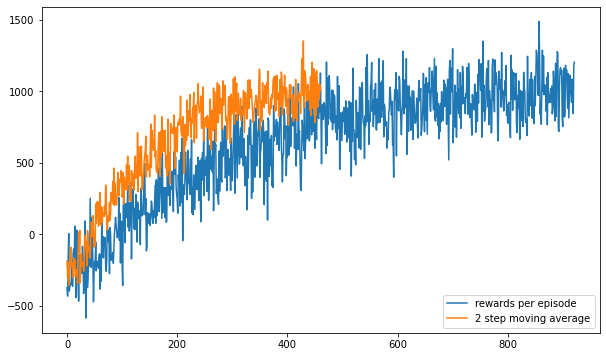

In [19]:
#plotting convergence with the 2 step moving average
plt.figure(figsize= (10, 6))
plt.plot(rewards_per_episode, label= 'rewards per episode')
plt.plot(wt_average(rewards_per_episode, 2), label= '2 step moving average')
plt.legend(loc= 'lower right')

## Epsilon-decay sample function

In [13]:
#defining epsilon decay function
def epsilon_decay(ep_count,epsilon_decay= 4e-3):
    epsilon = 1*((1- epsilon_decay)**ep_count) 
    return epsilon

In [14]:
#Generating epsilon values
epsilon= [epsilon_decay(x) for x in range(1000)]

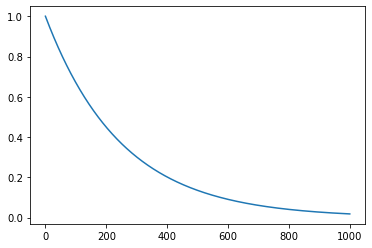

In [15]:
#plotting epsilon values
plt.plot(epsilon)